# **Import Libraries**

In [207]:
import numpy as np
import pandas as pd
import sys
import time
import random
import math
from scipy import linalg
import cv2
import string
from PIL import Image, ImageDraw
from PIL.Image import fromarray
import os
import re
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cat
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import resnet
from torchvision.models import resnet101, resnet34, resnet18
from torchvision.models import inception_v3
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, RandomSampler
import torch.autograd as autograd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Dataloader**

In [208]:
import torch
from torchvision import datasets, transforms


# Define transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

# Define paths to the train and test data directories
train_data_path = '/kaggle/input/stl10-png/STL10/Train'
test_data_path = '/kaggle/input/stl10-png/STL10/Test'

# Create datasets
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Define batch size for the data loader
batch_size = 64

# Define validation split
valid_size = 0.3  # 20% of the train set for validation

# Split train data into train and validation sets
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(valid_loader))

55 24


# **Visualize the data**

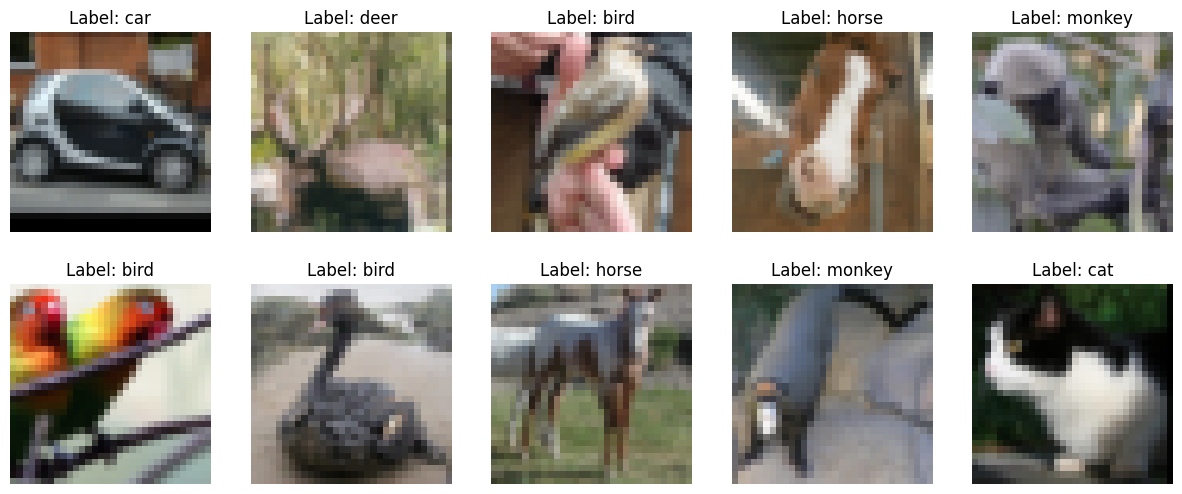

In [209]:
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

def unnormalize(img):
    img = img / 2 + 0.5
    return img.permute(1, 2, 0)  

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(figsize=(15, 6), nrows=2, ncols=5)
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(unnormalize(images[i]))
    ax.axis('off')
    ax.set_title(f'Label: {label[labels[i].item()]}')
plt.show()

# Lets Train The Clean Model and Evaluate it

In [210]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= total_steps
        train_acc = train_correct / train_total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Evaluation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [211]:
# Using ResNet-18
no_noise_model = resnet18(pretrained=True)
num_features = no_noise_model.fc.in_features
no_noise_model.fc = nn.Linear(num_features, 10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(no_noise_model.parameters(), lr=1e-3)

# Training
no_noise_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(no_noise_model, criterion, optimizer, train_loader, test_loader)

Epoch [1/15], Train Loss: 1.6943, Train Acc: 0.3940, Val Loss: 1.4433, Val Acc: 0.5101
Epoch [2/15], Train Loss: 1.4906, Train Acc: 0.4451, Val Loss: 1.4337, Val Acc: 0.4875
Epoch [3/15], Train Loss: 1.3097, Train Acc: 0.5260, Val Loss: 1.3661, Val Acc: 0.5189
Epoch [4/15], Train Loss: 1.0795, Train Acc: 0.6111, Val Loss: 1.2231, Val Acc: 0.5515
Epoch [5/15], Train Loss: 0.8999, Train Acc: 0.6849, Val Loss: 1.2448, Val Acc: 0.5831
Epoch [6/15], Train Loss: 0.7775, Train Acc: 0.7186, Val Loss: 1.2313, Val Acc: 0.6199
Epoch [7/15], Train Loss: 0.6766, Train Acc: 0.7614, Val Loss: 1.3050, Val Acc: 0.5793
Epoch [8/15], Train Loss: 0.5615, Train Acc: 0.8043, Val Loss: 1.2143, Val Acc: 0.6094
Epoch [9/15], Train Loss: 0.4392, Train Acc: 0.8514, Val Loss: 1.5420, Val Acc: 0.5676
Epoch [10/15], Train Loss: 0.3868, Train Acc: 0.8680, Val Loss: 1.4800, Val Acc: 0.5966
Epoch [11/15], Train Loss: 0.2531, Train Acc: 0.9186, Val Loss: 1.5986, Val Acc: 0.6076
Epoch [12/15], Train Loss: 0.3649, Train 

In [212]:
torch.save(no_noise_model.state_dict(), 'no_noise_model.pth')

# **Plot the Train and Accuracy plots for the Clean Model**

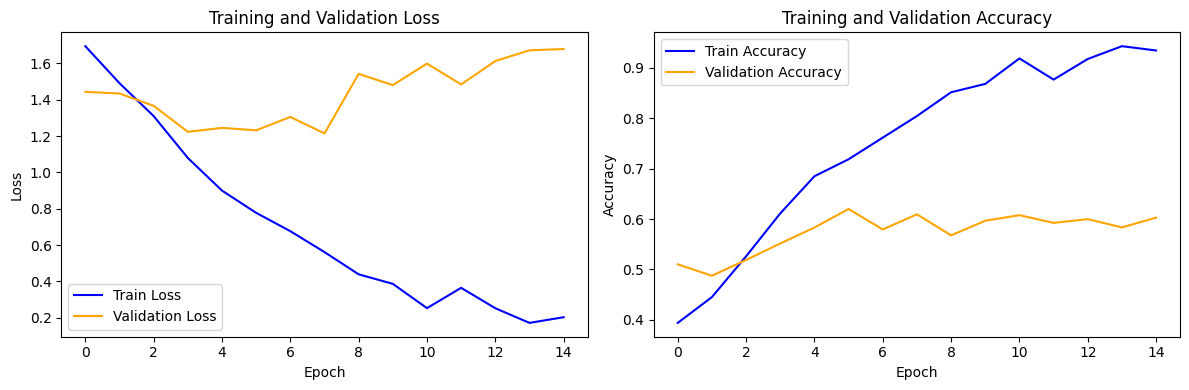

In [213]:
 plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

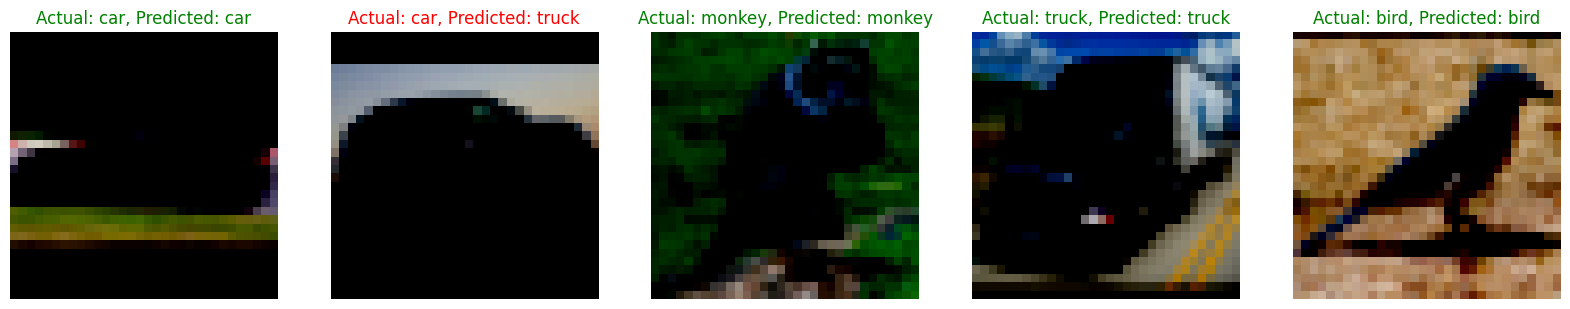

In [214]:
no_noise_model.eval()
num_images = 5

# Iterate through the test loader
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = no_noise_model(images)
        _, predicted = torch.max(outputs, 1)
        total_images = images.size(0)
        
        # Plot the images
        plt.figure(figsize=(20, 4))
        for j in range(min(num_images, total_images)):
            plt.subplot(1, num_images, j+1)
            image = images[j].cpu().numpy().transpose((1, 2, 0))
            actual_label = label[labels[j].item()]
            predicted_label = label[predicted[j].item()]
            text_color = 'green' if actual_label == predicted_label else 'red'
            plt.imshow(image)
            plt.axis('off')
            plt.title(f'Actual: {actual_label}, Predicted: {predicted_label}', color=text_color)
        plt.show()
        
        break

# **Noisy Layer**

In [215]:
class NoisyLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=None, stride=1, padding=0, bias=True, dropout_rate=0.2):
        super(NoisyLayer, self).__init__()
#         print(kernel_size)
        if kernel_size is not None:  # Convolutional layer
            self.noisy_layer = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=bias
            )
        else:  # Fully connected layer
            self.noisy_layer = nn.Linear(in_channels, out_channels, bias=bias)
            
        self.dropout = nn.Dropout2d(p=dropout_rate) if out_channels else nn.Dropout(p=dropout_rate)

    def forward(self, x):
        noise_scaling_factor = nn.Parameter(torch.Tensor([0.25]), requires_grad=True).to(x.device)
        
        with torch.no_grad():
            noise_std_dev = self.noisy_layer.weight.std().item()
            noise = self.noisy_layer.weight.clone().normal_(0, noise_std_dev).to(x.device)
            
        noisy_weight = self.noisy_layer.weight + noise_scaling_factor * noise
        noisy_output = F.conv2d(x, noisy_weight, bias=self.noisy_layer.bias, stride=self.noisy_layer.stride, padding=self.noisy_layer.padding) if hasattr(self.noisy_layer, 'kernel_size') else F.linear(x, noisy_weight, self.noisy_layer.bias)
        noisy_output = self.dropout(noisy_output)
        
        return noisy_output

# **Noising ResNet Model**

In [216]:
class NoisyResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.1):
        super(NoisyResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
#         self.resnet = MNIST_ResNet18()
    
        # Create a list of modules to avoid RuntimeError
        modules = list(self.resnet.modules())
        
        for module in modules:
            if isinstance(module, nn.Conv2d):
                noisy_conv = NoisyLayer(
                    in_channels=module.in_channels,
                    out_channels=module.out_channels,
                    kernel_size=module.kernel_size,
                    stride=module.stride,
                    padding=module.padding,
                    bias=module.bias is not None,
                    dropout_rate=dropout_rate
                )
                noisy_conv.noisy_layer.weight.data = module.weight.data
                if module.bias is not None:
                    noisy_conv.noisy_layer.bias.data = module.bias.data
                setattr(self.resnet, module._get_name(), noisy_conv)
                
        # Replace the final linear layer with a NoisyLayer
        self.resnet.fc = NoisyLayer(
            in_channels=self.resnet.fc.in_features,
            out_channels=num_classes,  # Set out_channels to num_classes
            bias=True,
            dropout_rate=dropout_rate
        )

    def forward(self, x):
        return self.resnet(x)



# **PGD Adversarial Attack**

In [217]:
class PGD_AdversarialAttack(nn.Module):
    def __init__(self, epsilon=1e-2, alpha=0.01, num_steps=7, random_start=True):
        super(PGD_AdversarialAttack, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_steps = num_steps
        self.random_start = random_start

    def forward(self, x, y, model):
        model.eval()
        perturbed_x = x.clone()
        perturbed_x.requires_grad = True

        x_max = x + self.epsilon
        x_min = x - self.epsilon
        x_max.clamp_(0, 1)
        x_min.clamp_(0, 1)

        if self.random_start:
            with torch.no_grad():
                perturbed_x.data = x + perturbed_x.uniform_(-self.epsilon, self.epsilon)
                perturbed_x.data.clamp_(0, 1)

        for _ in range(self.num_steps):
            output = model(perturbed_x)
            loss = F.cross_entropy(output, y)

            if perturbed_x.grad is not None:
                perturbed_x.grad.data.zero_()

            loss.backward()
            x_grad = perturbed_x.grad.data

            with torch.no_grad():
                perturbed_x.data += self.alpha * torch.sign(x_grad)
                perturbed_x.data = torch.max(torch.min(perturbed_x, x_max), x_min)

        perturbed_x.requires_grad = False
        return perturbed_x


# **FGSM Adversarial Attack**

In [218]:
class FGSM_AdversarialAttack(nn.Module):
    def __init__(self, epsilon=1e-2):
        super(FGSM_AdversarialAttack, self).__init__()
        self.epsilon = epsilon

    def forward(self, input_data, target, model, normalize=True):
        model.eval()
        
        # Enable gradient calculation for input data
        input_data.requires_grad = True
        
        # Forward pass
        output = model(input_data)
        
        # Calculate the loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output, target)
        
        # Backpropagate to get gradients
        loss.backward()
        
        # Get the gradient of the input with respect to the loss
        input_gradient = input_data.grad
        
        # Compute the sign of the gradient
        sign_input_gradient = torch.sign(input_gradient)
        
        # Generate adversarial perturbation
        perturbed_data = input_data + self.epsilon * sign_input_gradient
        
        # If normalize is True, clip perturbed data within valid range [0, 1]
        if normalize:
            perturbed_data.clamp_(0, 1)
        
        return perturbed_data

# **DeepFool Adversarial Attack**

In [219]:
class DeepFool_AdversarialAttack(nn.Module):
    def __init__(self, num_classes=10, overshoot=0.02, max_iter=10):
        super(DeepFool_AdversarialAttack, self).__init__()
        self.num_classes = num_classes
        self.overshoot = overshoot
        self.max_iter = max_iter

    def forward(self, input_image, model):
        model.eval()
        image = input_image.clone().detach().requires_grad_(True)
        image_shape = image.shape

        logits = model(image).data.cpu().numpy().flatten()
        sorted_logits_indices = (np.array(logits)).flatten().argsort()[::-1]
        sorted_logits_indices = sorted_logits_indices[0:self.num_classes]
        target_label = sorted_logits_indices[0]

        perturbed_image = copy.deepcopy(image)
        weight_vector = np.zeros(image_shape)
        perturbation_vector = np.zeros(image_shape)

        iteration = 0

        while iteration < self.max_iter:
            outputs = model(perturbed_image)
            logits_list = [outputs[0, sorted_logits_indices[k]] for k in range(self.num_classes)]
            predicted_label = np.argmax(outputs.data.cpu().numpy().flatten())

            if predicted_label == target_label:
                min_perturbation = np.inf
                outputs[0, sorted_logits_indices[0]].backward(retain_graph=True)
                original_gradient = perturbed_image.grad.data.cpu().numpy().copy()

                for k in range(1, self.num_classes):
                    perturbed_image.grad.data.zero_()
                    outputs[0, sorted_logits_indices[k]].backward(retain_graph=True)
                    current_gradient = perturbed_image.grad.data.cpu().numpy().copy()

                    # Compute weight vector and logit difference
                    weight_vector_k = current_gradient - original_gradient
                    logit_difference = (outputs[0, sorted_logits_indices[k]] - outputs[0, sorted_logits_indices[0]]).data.cpu().numpy()

                    perturbation_k = abs(logit_difference) / np.linalg.norm(weight_vector_k.flatten())

                    # Update weight vector and minimum perturbation
                    if perturbation_k < min_perturbation:
                        min_perturbation = perturbation_k
                        weight_vector = weight_vector_k

                # Compute perturbation update
                perturbation_update = (min_perturbation + 1e-4) * weight_vector / np.linalg.norm(weight_vector)
                perturbation_vector = np.float32(perturbation_vector + perturbation_update)

                perturbed_image = input_image + (1 + self.overshoot) * torch.from_numpy(perturbation_vector).to(input_image.device)
                perturbed_image.requires_grad_(True)
                iteration += 1
            else:
                break

        perturbation_vector = (1 + self.overshoot) * perturbation_vector
        perturbed_image = input_image + torch.from_numpy(perturbation_vector).to(input_image.device)
        perturbed_image.requires_grad_(False)

        return perturbed_image

# **Train the Noise Model**

In [220]:
def train_noise_model(model, train_loader, val_loader, num_epochs, attacker, criterion, optimizer, wt_clean=0.5, wt_noise=0.5):
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            
            clean_loss = criterion(model(images), targets)
            noisy_loss = 0
            try:
                noisy_images = attacker(images, targets, model).to(device)
                noisy_loss = criterion(model(noisy_images), targets)
            except RuntimeError:
                pass
            
            loss = wt_clean * clean_loss + wt_noise * noisy_loss
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = model(images).max(1)
            correct_train += predicted.eq(targets).sum().item()
            total_train += targets.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct_train / total_train)
        
        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                
                clean_loss = criterion(model(images), targets)
                noisy_loss = 0
                try:
                    noisy_images = attacker(images, targets, model).to(device)
                    noisy_loss = criterion(model(noisy_images), targets)
                except RuntimeError:
                    pass
                
                loss = wt_clean * clean_loss + wt_noise * noisy_loss
                val_loss += loss.item()
                
                _, predicted = model(images).max(1)
                correct_val += predicted.eq(targets).sum().item()
                total_val += targets.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct_val / total_val)
        
        print(f"Epoch {epoch+1}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}"
        )
    
    return model, train_losses, train_accs, val_losses, val_accs


In [221]:
noise_model = NoisyResNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(noise_model.parameters(), lr=1e-3)
num_epochs = 15
#
attacker = PGD_AdversarialAttack()

noise_model, train_loss_history_noise, train_acc_history_noise, val_loss_history_noise, val_acc_history_noise = train_noise_model(noise_model, train_loader, valid_loader, num_epochs, attacker, criterion, optimizer)

Epoch 1, Train Loss: 2.1921, Train Acc: 0.1783, Val Loss: 0.9263, Val Acc: 0.1780
Epoch 2, Train Loss: 1.9380, Train Acc: 0.2531, Val Loss: 0.8947, Val Acc: 0.2273
Epoch 3, Train Loss: 1.8642, Train Acc: 0.3097, Val Loss: 0.8223, Val Acc: 0.3233
Epoch 4, Train Loss: 1.7387, Train Acc: 0.3769, Val Loss: 0.7697, Val Acc: 0.3833
Epoch 5, Train Loss: 1.6765, Train Acc: 0.4246, Val Loss: 0.7330, Val Acc: 0.4467
Epoch 6, Train Loss: 1.5896, Train Acc: 0.4903, Val Loss: 0.7527, Val Acc: 0.3913
Epoch 7, Train Loss: 1.5111, Train Acc: 0.5329, Val Loss: 0.6903, Val Acc: 0.4653
Epoch 8, Train Loss: 1.3891, Train Acc: 0.6043, Val Loss: 0.6682, Val Acc: 0.5013
Epoch 9, Train Loss: 1.3059, Train Acc: 0.6591, Val Loss: 0.6766, Val Acc: 0.5120
Epoch 10, Train Loss: 1.2389, Train Acc: 0.6937, Val Loss: 0.5929, Val Acc: 0.5720
Epoch 11, Train Loss: 1.0895, Train Acc: 0.7611, Val Loss: 0.6610, Val Acc: 0.5100
Epoch 12, Train Loss: 0.9612, Train Acc: 0.8180, Val Loss: 0.6509, Val Acc: 0.5393
Epoch 13, Tra

# **Plot of Train Loss and Accuracy Vs Epochs for the Noise Model**

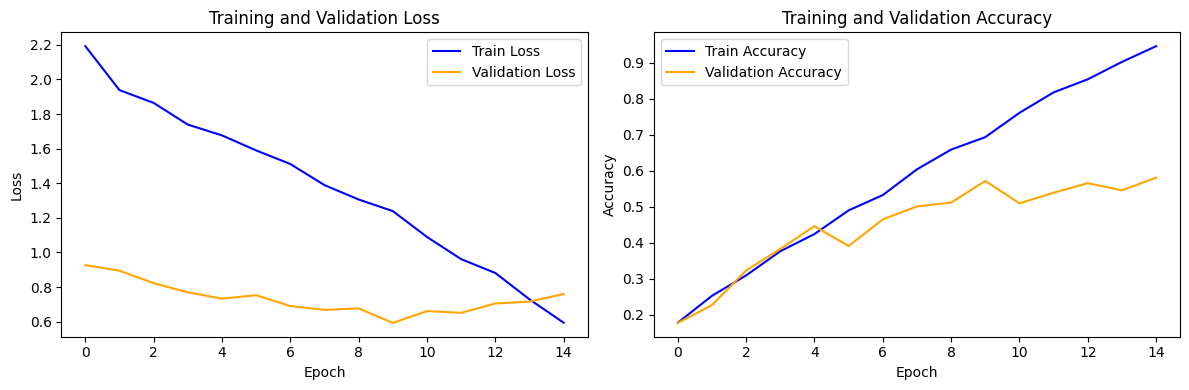

In [222]:
 plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_noise, label='Train Loss', color='blue')
plt.plot(val_loss_history_noise, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_noise, label='Train Accuracy', color='blue')
plt.plot(val_acc_history_noise, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [223]:
torch.save(noise_model.state_dict(), 'noise_model.pth')

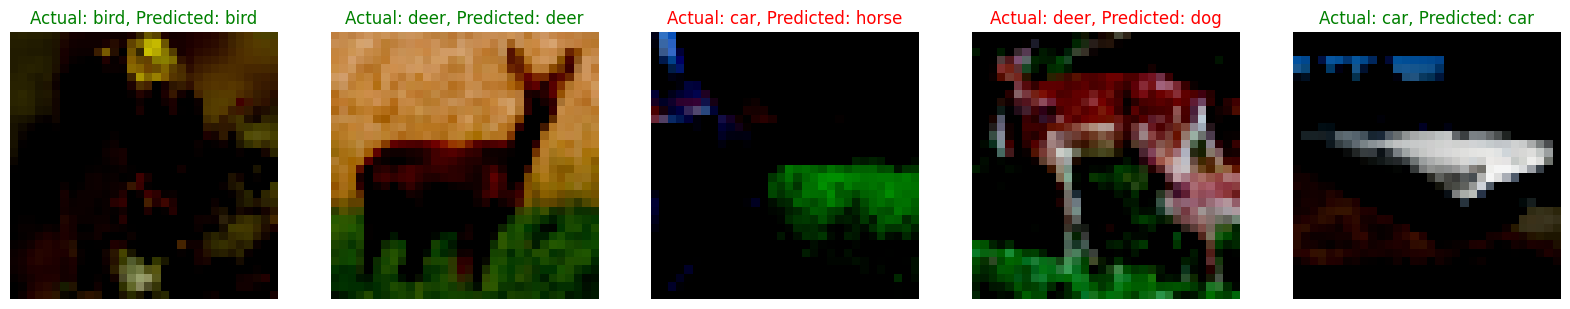

In [224]:
noise_model.eval()
num_images = 5

# Iterate through the test loader
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = noise_model(images)
        _, predicted = torch.max(outputs, 1)
        total_images = images.size(0)
        
        # Plot the images
        plt.figure(figsize=(20, 4))
        for j in range(min(num_images, total_images)):
            plt.subplot(1, num_images, j+1)
            image = images[j].cpu().numpy().transpose((1, 2, 0))
            actual_label = label[labels[j].item()]
            predicted_label = label[predicted[j].item()]
            text_color = 'green' if actual_label == predicted_label else 'red'
            plt.imshow(image)
            plt.axis('off')
            plt.title(f'Actual: {actual_label}, Predicted: {predicted_label}', color=text_color)
        plt.show()
        
        break

# **Visualization of the Original Image + Noise = Adversarial Image**

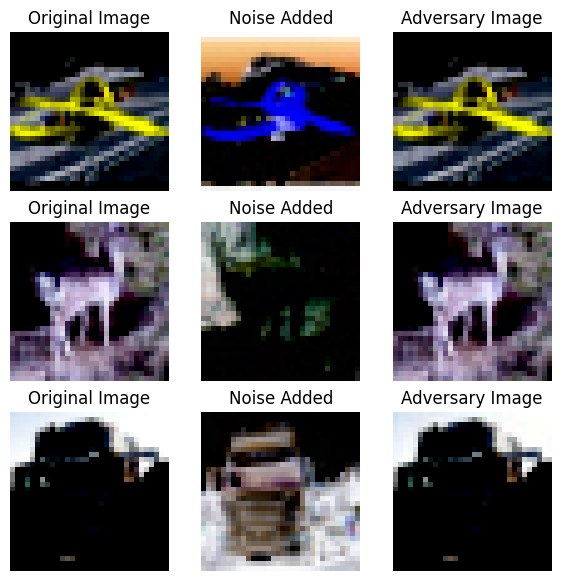

In [225]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7))

for images, labels in valid_loader:
    for i in range(3):
        image = images[i]
        label = labels[i]
        attacked_image = attacker(image.unsqueeze(0).to(device), label.unsqueeze(0).to(device), no_noise_model).cpu().detach().squeeze()

        noise_added = attacked_image - image

        ax[i][0].imshow(image.permute(1, 2, 0))
        ax[i][0].axis('off')
        ax[i][0].set_title('Original Image')

        ax[i][1].imshow(noise_added.permute(1, 2, 0))
        ax[i][1].axis('off')
        ax[i][1].set_title('Noise Added')

        ax[i][2].imshow(attacked_image.permute(1, 2, 0))
        ax[i][2].axis('off')
        ax[i][2].set_title('Adversary Image')

# **Robust and Normal Prediction for FGSM Adversarial Attack for Clean Model**

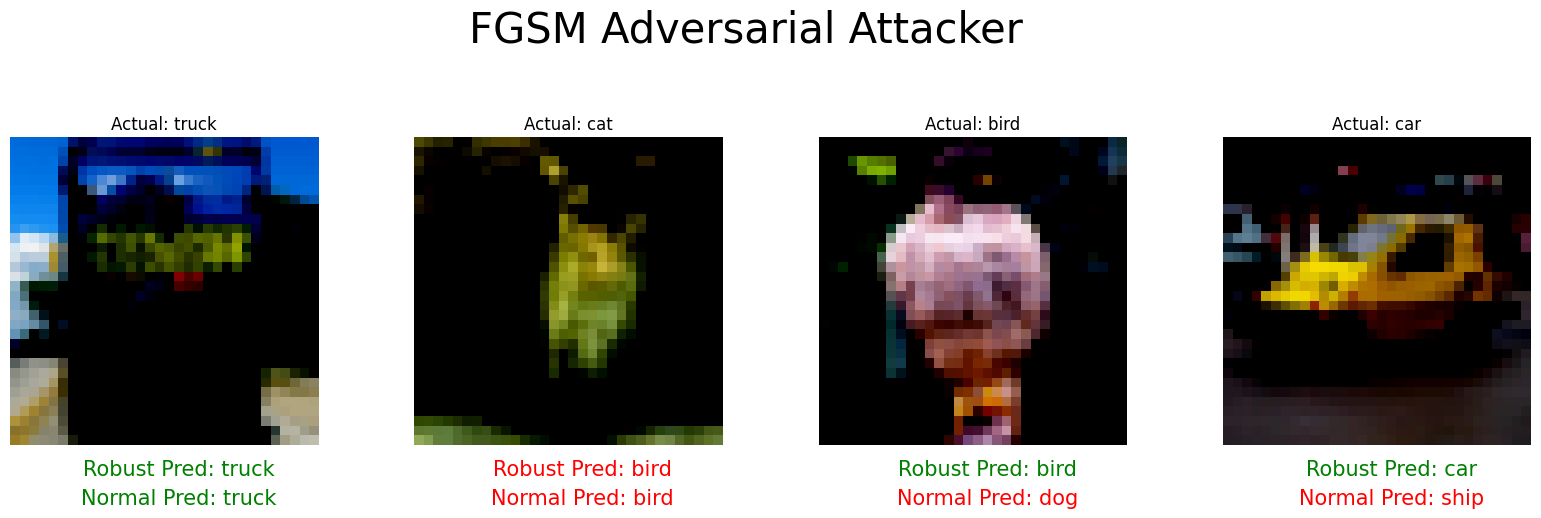

In [226]:
fgsm_attacker = FGSM_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = fgsm_attacker(image.unsqueeze(0).to(device), lab.unsqueeze(0).to(device), no_noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('FGSM Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break


# **Robust and Normal Prediction for PGD Adversarial Attack for Clean Model**

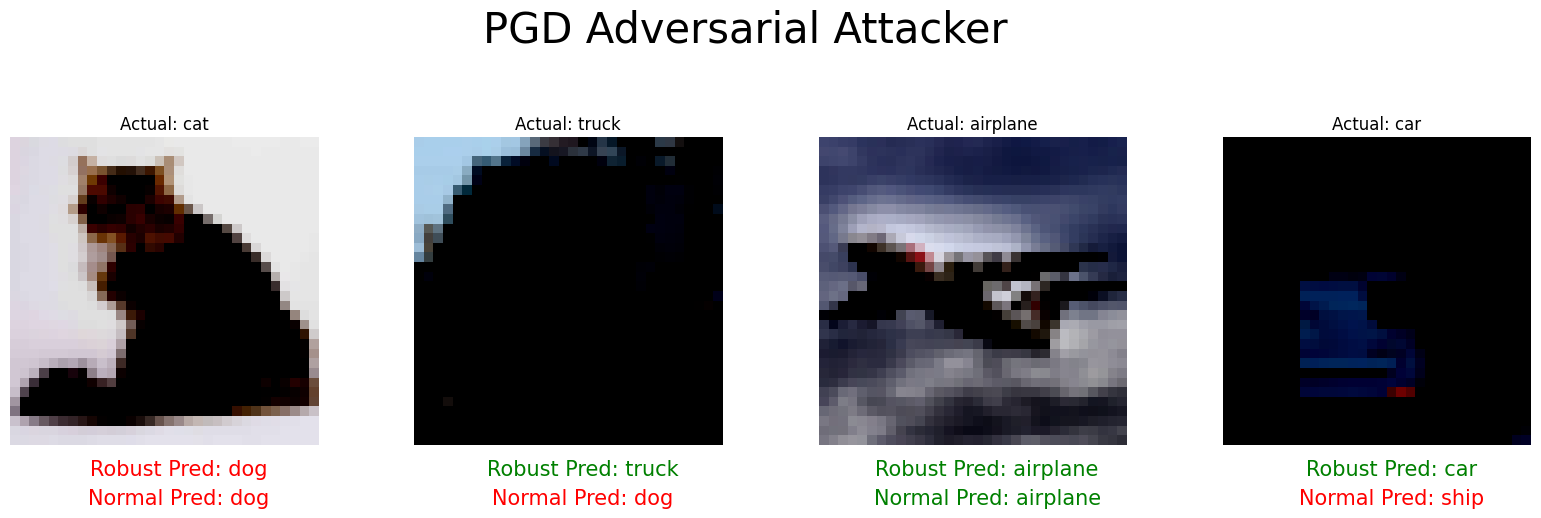

In [227]:
pgd_attacker = PGD_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = pgd_attacker(image.unsqueeze(0).to(device), lab.unsqueeze(0).to(device), no_noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('PGD Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break

# **Robust and Normal Prediction for DeepFool Adversarial Attack for Clean Model**

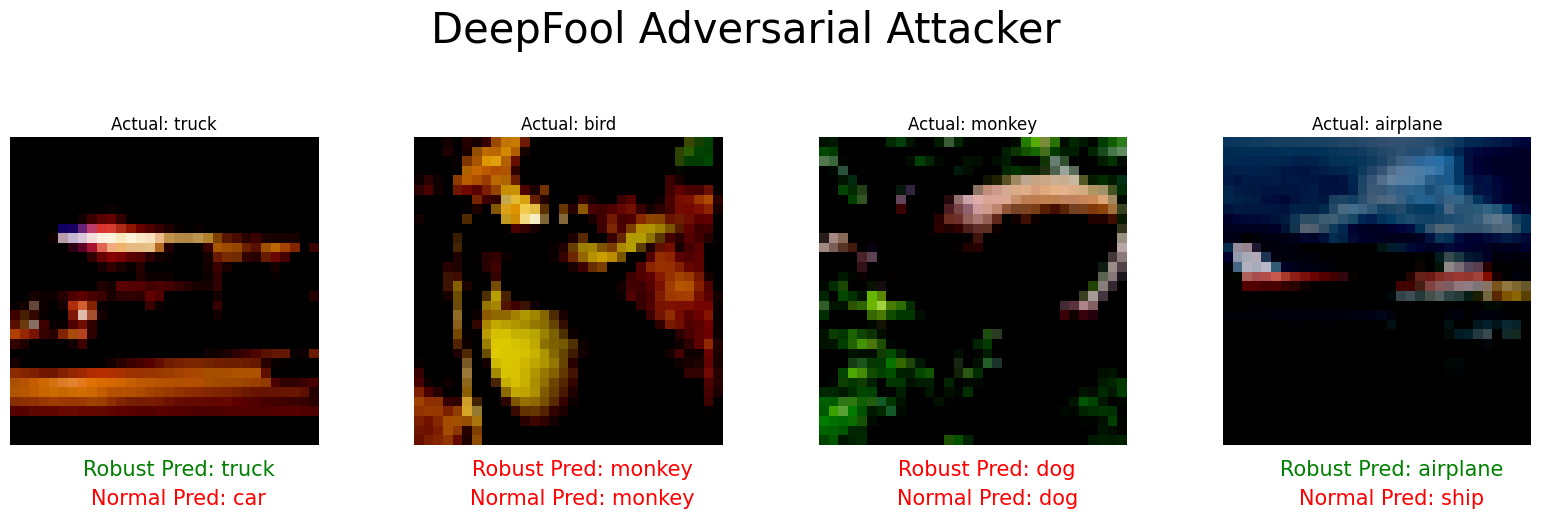

In [228]:
DeepFool_attacker = DeepFool_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = DeepFool_attacker(image.unsqueeze(0).to(device), no_noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('DeepFool Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break

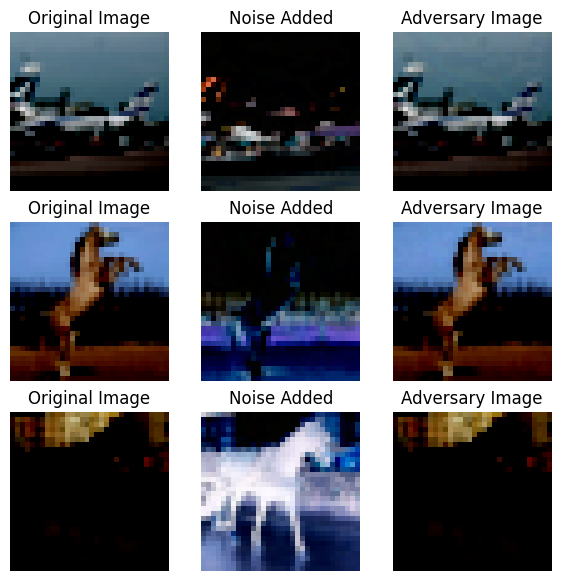

In [229]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7))

for images, labels in valid_loader:
    for i in range(3):
        image = images[i]
        label = labels[i]
        attacked_image = attacker(image.unsqueeze(0).to(device), label.unsqueeze(0).to(device), noise_model).cpu().detach().squeeze()

        noise_added = attacked_image - image

        ax[i][0].imshow(image.permute(1, 2, 0))
        ax[i][0].axis('off')
        ax[i][0].set_title('Original Image')

        ax[i][1].imshow(noise_added.permute(1, 2, 0))
        ax[i][1].axis('off')
        ax[i][1].set_title('Noise Added')

        ax[i][2].imshow(attacked_image.permute(1, 2, 0))
        ax[i][2].axis('off')
        ax[i][2].set_title('Adversary Image')

# **Robust and Normal Prediction for FGSM Adversarial Attack for Noise Model**

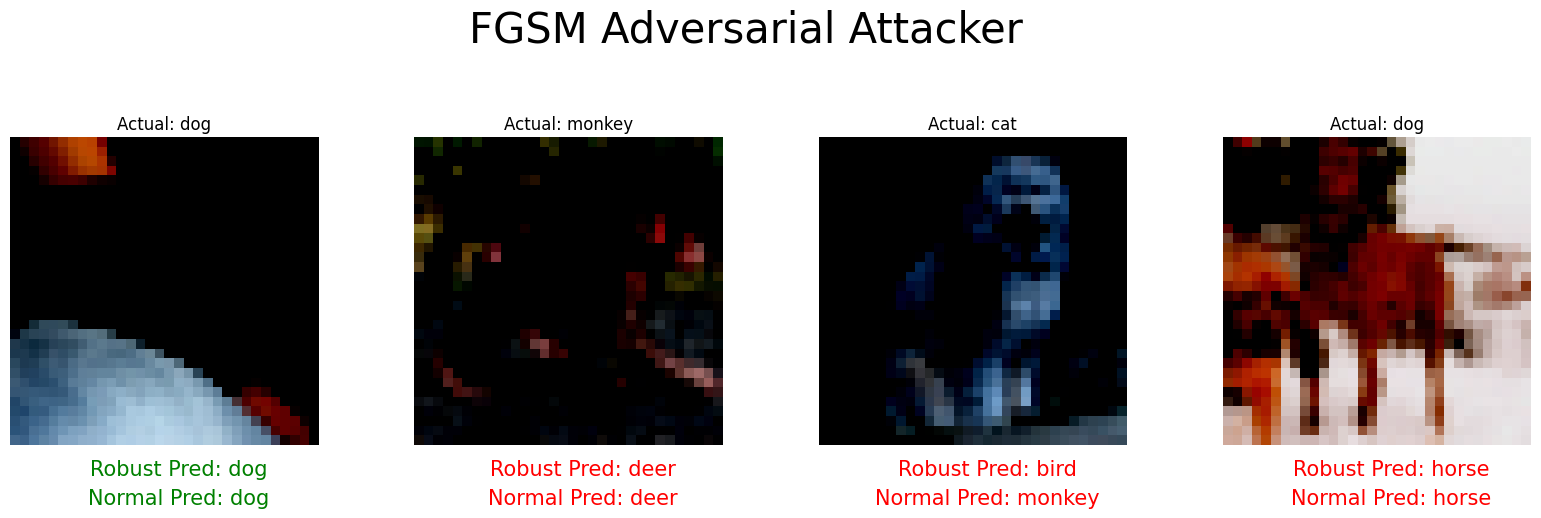

In [230]:
fgsm_attacker = FGSM_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = fgsm_attacker(image.unsqueeze(0).to(device), lab.unsqueeze(0).to(device), noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('FGSM Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break


# **Robust and Normal Prediction for PGD Adversarial Attack for Noise Model**

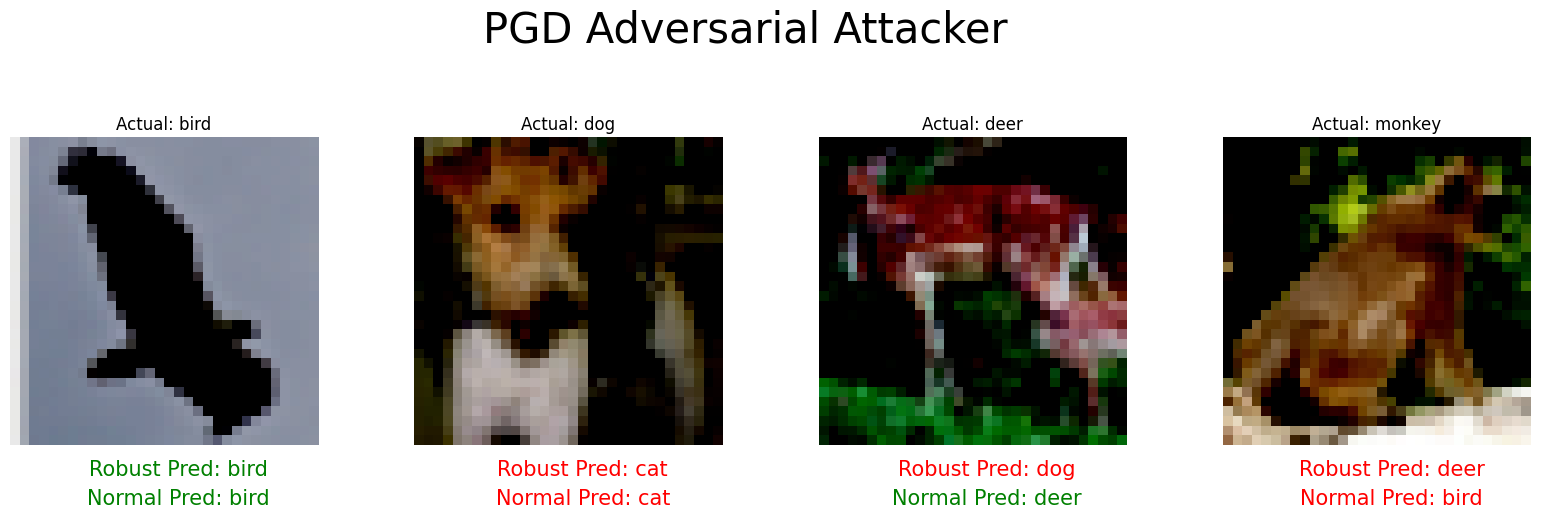

In [231]:
pgd_attacker = PGD_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = pgd_attacker(image.unsqueeze(0).to(device), lab.unsqueeze(0).to(device), noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('PGD Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break

# **Robust and Normal Prediction for DeepFool Adversarial Attack for Noise Model**

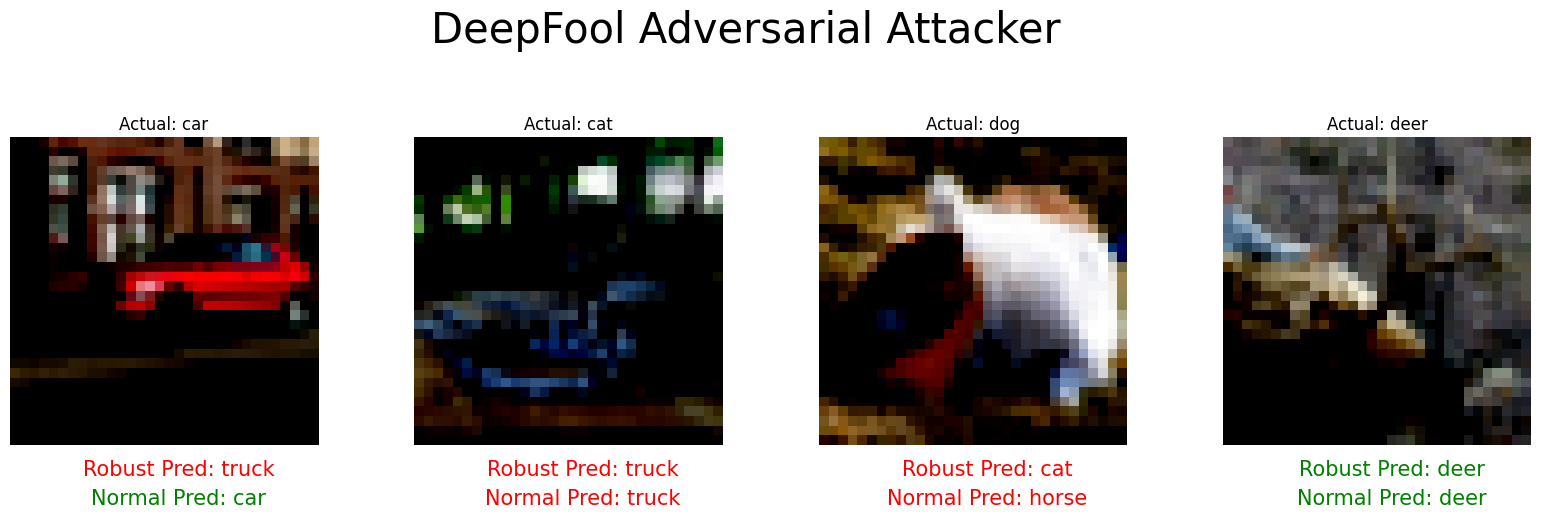

In [232]:
DeepFool_attacker = DeepFool_AdversarialAttack().to(device)
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
label = {0: "airplane", 1:"bird", 2:"car", 3:"cat", 4:"deer", 5:"dog", 6:"horse", 7:"monkey", 8:"ship", 9:"truck"}

for images, labels in valid_loader:
    for i in range(4):
        image = images[i]
        lab = labels[i]
        attacked_image = DeepFool_attacker(image.unsqueeze(0).to(device), noise_model).to(device)

        noise_pred = noise_model(attacked_image).argmax(1)
        clean_pred = no_noise_model(attacked_image).argmax(1)
        
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title(f'Actual: {label[lab.item()]}', fontsize=12)
        
        # Set text color based on prediction correctness
        robust_color = 'green' if noise_pred[0].item() == lab.item() else 'red'
        normal_color = 'green' if clean_pred[0].item() == lab.item() else 'red'
        
        ax[i].text(17, 34, f'Robust Pred: {label[noise_pred[0].item()]}', color=robust_color, ha='center', va='center', fontsize=15)
        ax[i].text(17, 37, f'Normal Pred: {label[clean_pred[0].item()]}', color=normal_color, ha='center', va='center', fontsize=15)
        
        ax[i].axis('off')

    plt.suptitle('DeepFool Adversarial Attacker', y=1.2, fontsize=30)
    plt.show()
    
    break

In [233]:
fgsm_attacker = FGSM_AdversarialAttack().to(device)

standard_fgsm_accuracies = []
robust_fgsm_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    attacked_images = fgsm_attacker(images, labels, no_noise_model)
    
    robust_pred = noise_model(attacked_images).argmax(1)
    standard_pred = no_noise_model(attacked_images).argmax(1)

    total = labels.size(0)
    robust_correct = (robust_pred == labels).sum().item()
    std_correct = (standard_pred == labels).sum().item()
    
    standard_accuracy = std_correct / total
    robust_accuracy = robust_correct / total
    
    standard_fgsm_accuracies.append(standard_accuracy)
    robust_fgsm_accuracies.append(robust_accuracy)

In [234]:
pgd_attacker = PGD_AdversarialAttack().to(device)

standard_pgd_accuracies = []
robust_pgd_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    attacked_images = pgd_attacker(images, labels, no_noise_model)
    
    robust_pred = noise_model(attacked_images).argmax(1)
    standard_pred = no_noise_model(attacked_images).argmax(1)

    total = labels.size(0)
    robust_correct = (robust_pred == labels).sum().item()
    std_correct = (standard_pred == labels).sum().item()
    
    standard_accuracy = std_correct / total
    robust_accuracy = robust_correct / total
    
    standard_pgd_accuracies.append(standard_accuracy)
    robust_pgd_accuracies.append(robust_accuracy)

In [241]:
deepfool_attacker = DeepFool_AdversarialAttack().to(device)

standard_deepfool_accuracies = []
robust_deepfool_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    attacked_images = deepfool_attacker(images, no_noise_model)
    
    robust_pred = noise_model(attacked_images).argmax(1)
    standard_pred = no_noise_model(attacked_images).argmax(1)

    total = labels.size(0)
    robust_correct = (robust_pred == labels).sum().item()
    std_correct = (standard_pred == labels).sum().item()
    
    standard_accuracy = std_correct / total
    robust_accuracy = robust_correct / total
    
    standard_deepfool_accuracies.append(standard_accuracy)
    robust_deepfool_accuracies.append(robust_accuracy)

# **Standard and Robust Model Accuracies under Different Attacks**

In [236]:
fgsm_mean, fgsm_std = np.mean(standard_fgsm_accuracies), np.std(standard_fgsm_accuracies)
fgsm_robust_mean, fgsm_robust_std = np.mean(robust_fgsm_accuracies), np.std(robust_fgsm_accuracies)


pgd_mean, pgd_std = np.mean(standard_pgd_accuracies), np.std(standard_pgd_accuracies)
pgd_robust_mean, pgd_robust_std = np.mean(robust_pgd_accuracies), np.std(robust_pgd_accuracies)

deepfool_mean, deepfool_std = np.mean(standard_deepfool_accuracies), np.std(standard_deepfool_accuracies)
deepfool_robust_mean, deepfool_robust_std = np.mean(robust_deepfool_accuracies), np.std(robust_deepfool_accuracies)

data = {
    'Attack': ['FGSM', 'FGSM', 'PGD', 'PGD', 'Deep Fool', 'Deep Fool'],
    'Type': ['Standard', 'Robust', 'Standard', 'Robust', 'Standard', 'Robust'],
    'Mean': [fgsm_mean, fgsm_robust_mean, pgd_mean, pgd_robust_mean, deepfool_mean, deepfool_robust_mean],
    'Std': [fgsm_std, fgsm_robust_std, pgd_std, pgd_robust_std, deepfool_std, deepfool_robust_std],
    'Accuracy': [f'{np.round(fgsm_mean, 4)} ± {np.round(fgsm_std, 4)}', 
                 f'{np.round(fgsm_robust_mean, 4)} ± {np.round(fgsm_robust_std, 4)}',
                 f'{np.round(pgd_mean, 4)} ± {np.round(pgd_std, 4)}',
                 f'{np.round(pgd_robust_mean, 4)} ± {np.round(pgd_robust_std, 4)}',
                 f'{np.round(deepfool_mean, 4)} ± {np.round(deepfool_std, 4)}',
                 f'{np.round(deepfool_robust_mean, 4)} ± {np.round(deepfool_robust_std, 4)}',
                ]
}

df = pd.DataFrame(data)
df


,Attack,Type,Mean,Std,Accuracy
0,FGSM,Standard,0.282250,0.177809,0.2822 ± 0.1778
1,FGSM,Robust,0.453875,0.156598,0.4539 ± 0.1566
2,PGD,Standard,0.178500,0.148879,0.1785 ± 0.1489
3,PGD,Robust,0.453875,0.156473,0.4539 ± 0.1565
4,Deep Fool,Standard,0.199000,0.051500,0.199 ± 0.0515
5,Deep Fool,Robust,0.645900,0.062900,0.6459 ± 0.0629


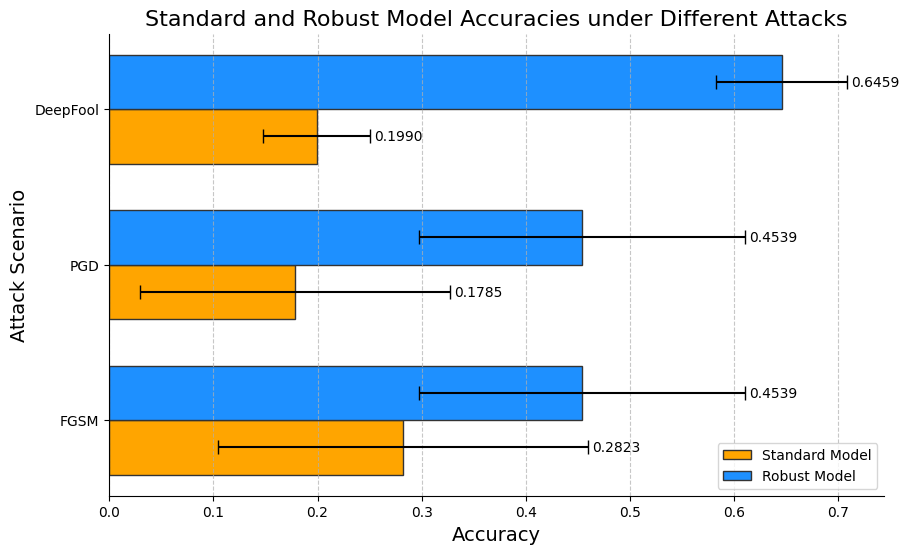

In [237]:
# Data
labels = ['FGSM', 'PGD', 'DeepFool']
standard_means = [fgsm_mean, pgd_mean, deepfool_mean]
standard_stds = [fgsm_std, pgd_std, deepfool_std]
robust_means = [fgsm_robust_mean, pgd_robust_mean, deepfool_robust_mean]
robust_stds = [fgsm_robust_std, pgd_robust_std, deepfool_robust_std]

x = np.arange(len(labels))  
width = 0.35 

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors
standard_color = '#FFA500'  # Orange
robust_color = '#1E90FF' 
error_color = '#333333'

# Plot bars
standard_bars = ax.barh(x - width/2, standard_means, width, xerr=standard_stds, label='Standard Model', capsize=5, color=standard_color, edgecolor=error_color)
robust_bars = ax.barh(x + width/2, robust_means, width, xerr=robust_stds, label='Robust Model', capsize=5, color=robust_color, edgecolor=error_color)

# Axis labels and title
ax.set_ylabel('Attack Scenario', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_title('Standard and Robust Model Accuracies under Different Attacks', fontsize=16)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()

# Bar labels
ax.bar_label(standard_bars, fmt='%.4f', padding=3, color='black', clip_on = False)
ax.bar_label(robust_bars, fmt='%.4f', padding=3, color='black', clip_on = False)

# Grid
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# **Class-Wise Accuracies Under PGD Adversarial Attack**

In [238]:
num_classes = 10
pgd_attacker = PGD_AdversarialAttack().to(device)

standard_class_accuracies = np.zeros(num_classes)
robust_class_accuracies = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    attacked_images = pgd_attacker(images, labels, no_noise_model)

    robust_pred = noise_model(attacked_images).argmax(1)
    standard_pred = no_noise_model(attacked_images).argmax(1)

    for i in range(num_classes):
        class_mask = (labels == i)
        total_per_class[i] += class_mask.sum().item()
        standard_class_accuracies[i] += (standard_pred[class_mask] == labels[class_mask]).sum().item()
        robust_class_accuracies[i] += (robust_pred[class_mask] == labels[class_mask]).sum().item()

standard_class_accuracies /= total_per_class
robust_class_accuracies /= total_per_class

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


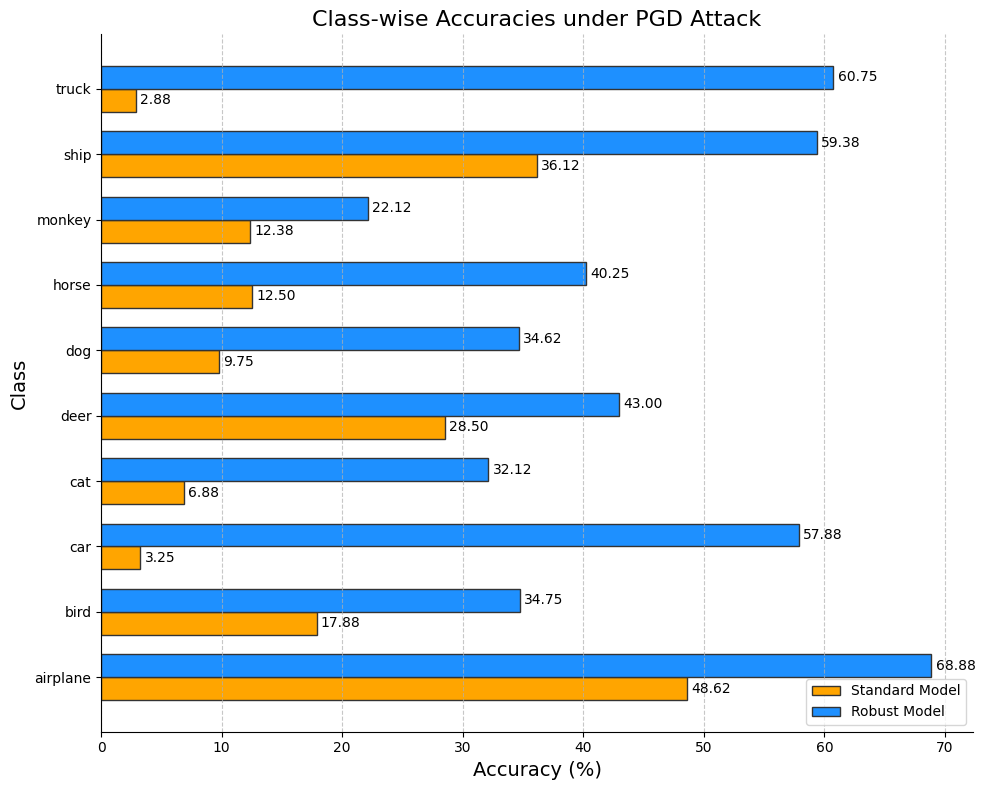

In [240]:
# Data
labels = [f'{label[i]}' for i in range(num_classes)]
x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Dark blue and orange colors
standard_color = '#FFA500'  # Orange
robust_color = '#1E90FF'    # Dark Blue

# Plot bars
standard_bars = ax.barh(x - width/2, standard_class_accuracies * 100, width, label='Standard Model', color=standard_color, edgecolor=error_color)
robust_bars = ax.barh(x + width/2, robust_class_accuracies * 100, width, label='Robust Model', color=robust_color, edgecolor=error_color)

# Axis labels and title
ax.set_ylabel('Class', fontsize=14)
ax.set_xlabel('Accuracy (%)', fontsize=14)
ax.set_title('Class-wise Accuracies under PGD Attack', fontsize=16)
ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=10)
ax.legend()

# Bar labels
ax.bar_label(standard_bars, fmt='%.2f', padding=3, color='black', clip_on=False)
ax.bar_label(robust_bars, fmt='%.2f', padding=3, color='black', clip_on=False)

# Grid
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
